In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


pd.set_option('display.max_columns', None)
%matplotlib inline

# 1 Exploring the Data

In [3]:
df=pd.read_csv('Data/bank-full.csv',sep=";")

### 1.1 What does the data look like?

In [24]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### 1.2 Do the data types make sense?

**No.`campaign` is labeled as numerical, but not all of the values in the feature are numerical, as certain rows have a value of 999 to indicate the the person has never been contacted.**

In [28]:
#This code gives us indexes for the features of each type for later manipulation.
categorical=df.dtypes[df.dtypes=="object"].index
numerical=df.dtypes[df.dtypes!="object"].index

In [29]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

### 1.3 Are there any missing values?
**There are no null values. Nevertheless, when the dataset was printed, a number of "Unknown" values appeared in one of the columns. It appears that missing values where replaced with strings when the data was created. These must be inditified by looking at unique values.**

1. **`default` has 20% of its rows missing. The Database documentation does not explain if the data in this column was collected voluntarily. If so, it's possible that respondents with who have defaulted in the past left this blank intentionally. We keep the column, as null values could be significant**

2. **`education` contains around 4% unknwon values. As was the case with `default`, we retain these instances.**

3. **All other columns have a maximum of 2% missing values. We will look further into these when exploring cateogrical columns below.**

In [30]:
df.isna().sum()*100/len(df)

age               0.0
job               0.0
marital           0.0
education         0.0
default           0.0
housing           0.0
loan              0.0
contact           0.0
month             0.0
day_of_week       0.0
duration          0.0
campaign          0.0
pdays             0.0
previous          0.0
poutcome          0.0
emp.var.rate      0.0
cons.price.idx    0.0
cons.conf.idx     0.0
euribor3m         0.0
nr.employed       0.0
y                 0.0
dtype: float64

In [31]:
#This code creates a list containing the categorical features and prints the proportion of "unknown" values in each.
print("Missing rows:")
for i in categorical:
    print(i,":", round(df[i][df[i]=="unknown"].count()*100/len(df),ndigits=2),"%")


Missing rows:
job : 0.8 %
marital : 0.19 %
education : 4.2 %
default : 20.87 %
housing : 2.4 %
loan : 2.4 %
contact : 0.0 %
month : 0.0 %
day_of_week : 0.0 %
poutcome : 0.0 %
y : 0.0 %


In [33]:
df["default"].value_counts()*100/len(df)

no         79.120132
unknown    20.872584
yes         0.007284
Name: default, dtype: float64

In [32]:
df["education"].value_counts()*100/len(df)

university.degree      29.542585
high.school            23.101389
basic.9y               14.676605
professional.course    12.729436
basic.4y               10.138875
basic.6y                5.564728
unknown                 4.202680
illiterate              0.043702
Name: education, dtype: float64

### 1.4 Can categorical columns be encoded?
1. `education`: Can be one-hot encoded. Basic.4y and basic.6y can be grouped to reduce dimensionality.
2. `pdays`: Since a value of 999 denotes that a lead was not contacted for a previous campaign, this column must be transformed into a categorical one. Otherwise, the model will incorrectly attribute certain outcomes to a high number of days passed when, in reality, it should be attributed to no previous contact. This also means that, since the maximum value for days passed is only 27, the presence of a value of 999 will diminish the weight of the real numerical values. As such, we will transform this column into a binary categorical feature denoting whether a lead was or was not contacted for the previous campaign.
3. `job`: This column can be one-hot encoded. Nevertheless, certain categories should be grouped to reduce dimensionality.<br>The following categories can be combined: <br>
    housemaid<>blue-collar<br>
    student<>unemployed<br>
    entrepeneur<>self-employed<br>
    Once the data is encoded, the `unknown` column will be removed.
4. `marital` can be one-hot encoded as it is. Once the data is encoded, the `unknown` column will be removed.
5. `default`: Since respondents who default often decline to answer, and since the proportion of "yes" values is so small, we will combine "yes" and "unknown" values.
6. `housing` can be one-hot encoded as it is. Once the data is encoded, the `unknown` column will be removed.
6. `loan` can be one-hot encoded as it is. Once the data is encoded, the `unknown` column will be removed.
6. `contact` can be one-hot encoded as it is. 
6. `month` can be one-hot encoded as it is.
6. `day_of_week` can be one-hot encoded as it is.
6. `poutcome` can be one-hot encoded as it is.


In [210]:
categorical

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')

### **`education`**

In [38]:
df["education"].value_counts()*100/len(df)

university.degree      29.542585
high.school            23.101389
basic.9y               14.676605
professional.course    12.729436
basic.4y               10.138875
basic.6y                5.564728
unknown                 4.202680
illiterate              0.043702
Name: education, dtype: float64

In [51]:
df.replace(["basic.4y","basic.6y"],"basic.lower",inplace=True)
df_replace["education"].replace("basic.9y","basic.upper",inplace=True)

In [52]:
df["education"].value_counts()*100/len(df)

university.degree      29.542585
high.school            23.101389
basic.lower            15.703603
basic.upper            14.676605
professional.course    12.729436
unknown                 4.202680
illiterate              0.043702
Name: education, dtype: float64

### **`pdays`**

In [235]:
df["pdays"].value_counts()*100/len(df)

999    96.321744
3       1.065844
6       1.000291
4       0.286491
9       0.155385
2       0.148101
7       0.145673
12      0.140818
10      0.126250
5       0.111683
13      0.087404
11      0.067981
1       0.063125
15      0.058269
14      0.048558
8       0.043702
0       0.036418
16      0.026707
17      0.019423
18      0.016995
19      0.007284
22      0.007284
21      0.004856
26      0.002428
20      0.002428
25      0.002428
27      0.002428
Name: pdays, dtype: float64

In [53]:
df["pdays"][df["pdays"] != 999]=1  
df["pdays"][df["pdays"] == 999]=0  
df["pdays"].value_counts()*100/len(df)

<ipython-input-53-98db410a5b5c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pdays"][df["pdays"] != 999]=1
<ipython-input-53-98db410a5b5c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pdays"][df["pdays"] == 999]=0


0    96.321744
1     3.678256
Name: pdays, dtype: float64

### **`job`**

In [237]:
#Keep
df["job"].value_counts()*100/len(df)

admin.           25.303486
blue-collar      22.467709
technician       16.371273
services          9.636302
management        7.099155
retired           4.175974
entrepreneur      3.535010
self-employed     3.450034
housemaid         2.573565
unemployed        2.461882
student           2.124405
unknown           0.801204
Name: job, dtype: float64

In [54]:
df["job"].replace(["housemaid","blue-collar"],"housemaid/blue-collar",inplace=True)
df["job"].replace(["student","unemployed"],"student/unemployed",inplace=True)
df["job"].replace(["entrepreneur","self-employed"],"entrepeneur/self-employed",inplace=True)

In [55]:
df["job"].value_counts()*100/len(df)

admin.                       25.303486
housemaid/blue-collar        25.041274
technician                   16.371273
services                      9.636302
management                    7.099155
entrepeneur/self-employed     6.985044
student/unemployed            4.586287
retired                       4.175974
unknown                       0.801204
Name: job, dtype: float64

### **`marital`**

In [56]:
df["marital"].value_counts()*100/len(df)

married     60.522482
single      28.085850
divorced    11.197436
unknown      0.194231
Name: marital, dtype: float64

### **`default`**

In [57]:
df["default"].value_counts()*100/len(df)

no         79.120132
unknown    20.872584
yes         0.007284
Name: default, dtype: float64

In [243]:
df["default"].replace("yes","unknown",inplace=True)

### **`housing`**

In [58]:
df["housing"].value_counts()*100/len(df)

yes        52.384190
no         45.212198
unknown     2.403613
Name: housing, dtype: float64

### **`loan`**

In [59]:
df["loan"].value_counts()*100/len(df)

no         82.426920
yes        15.169467
unknown     2.403613
Name: loan, dtype: float64

### **`contact`**

In [60]:
df["contact"].value_counts()*100/len(df)

cellular     63.474798
telephone    36.525202
Name: contact, dtype: float64

### **`day_of_week`**

In [61]:
df["day_of_week"].value_counts()*100/len(df)

thu    20.935709
mon    20.671069
wed    19.748470
tue    19.641643
fri    19.003108
Name: day_of_week, dtype: float64

### **`poutcome`**

In [62]:
df["poutcome"].value_counts()*100/len(df)

nonexistent    86.343110
failure        10.323395
success         3.333495
Name: poutcome, dtype: float64

### **Changes**

In [63]:
#Replace education categories
df["education"].replace(["basic.4y","basic.6y"],"basic.lower",inplace=True)
df["education"].replace("basic.9y","basic.upper",inplace=True)

#Replace pdays categories
df["pdays"][df["pdays"] != 999]=1  
df["pdays"][df["pdays"] == 999]=0  

#Replace job categories
df["job"].replace(["housemaid","blue-collar"],"housemaid/blue-collar",inplace=True)
df["job"].replace(["student","unemployed"],"student/unemployed",inplace=True)
df["job"].replace(["entrepreneur","self-employed"],"entrepeneur/self-employed",inplace=True)

#Replace default categories
df["default"].replace("yes","unknown",inplace=True)

#Create dumy variables
df_dummy=pd.get_dummies(df,drop_first=True)
df_dummy.drop(["job_unknown","marital_unknown","housing_unknown","loan_unknown"],axis="columns",inplace=True)
df_dummy

<ipython-input-63-de1b104fa77c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pdays"][df["pdays"] != 999]=1
<ipython-input-63-de1b104fa77c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pdays"][df["pdays"] == 999]=0


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_entrepeneur/self-employed,job_housemaid/blue-collar,job_management,job_retired,job_services,job_student/unemployed,job_technician,marital_married,marital_single,education_basic.upper,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,housing_yes,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y_yes
0,56,261,1,1,0,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
1,57,149,1,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
2,37,226,1,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
3,40,151,1,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
4,56,307,1,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,1,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
41184,46,383,1,1,0,-1.1,94.767,-50.8,1.028,4963.6,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
41185,56,189,2,1,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
41186,44,442,1,1,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1


### 1.5 Does the numerical data make sense?
1. `duration`: Each instance represents a unique phone call. Since the goal of this model is to predict whether a lead will convert before a phone call is made, and since the duration of a call cannot be known beforehand, this feature is useless to the model. 
1. `age`: Everything is in order.
2. `pdays`: Everything is in order.
2. `previous`: Everything is in order.
2. `emp.var.rate`: Everything is in order.
2. `cons.price.idx`: Everything is in order.
2. `cons.conf.idx`: Everything is in order.

**We will decide what to do with these columns once we look at value distribution in the distribution analysis**

In [192]:
numerical

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [10]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### **`age`**

In [191]:
df["age"].value_counts()

31    1947
32    1846
33    1833
36    1780
35    1759
      ... 
89       2
91       2
87       1
94       1
95       1
Name: age, Length: 78, dtype: int64

### **`duration`**

In [194]:
df["duration"].value_counts()

85      170
90      170
136     168
73      167
124     164
       ... 
1108      1
980       1
4918      1
2453      1
2015      1
Name: duration, Length: 1544, dtype: int64

### **`campaign`**

In [195]:
df["campaign"].value_counts()

1     17642
2     10570
3      5341
4      2651
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
15       51
16       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
25        8
26        8
28        8
30        7
31        7
35        5
33        4
32        4
34        3
40        2
42        2
43        2
37        1
39        1
41        1
56        1
Name: campaign, dtype: int64

### **`previous`**

In [202]:
df["previous"].value_counts()

0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: previous, dtype: int64

### **`emp.var.rate`**

In [204]:
df["emp.var.rate"].value_counts()

 1.4    16234
-1.8     9184
 1.1     7763
-0.1     3683
-2.9     1663
-3.4     1071
-1.7      773
-1.1      635
-3.0      172
-0.2       10
Name: emp.var.rate, dtype: int64

### **`cons.price.idx`**

In [205]:
df["cons.price.idx"].value_counts()

93.994    7763
93.918    6685
92.893    5794
93.444    5175
94.465    4374
93.200    3616
93.075    2458
92.201     770
92.963     715
92.431     447
92.649     357
94.215     311
94.199     303
92.843     282
92.379     267
93.369     264
94.027     233
94.055     229
93.876     212
94.601     204
92.469     178
93.749     174
92.713     172
94.767     128
93.798      67
92.756      10
Name: cons.price.idx, dtype: int64

### **`cons.conf.idx`**

In [206]:
df["cons.conf.idx"].value_counts()

-36.4    7763
-42.7    6685
-46.2    5794
-36.1    5175
-41.8    4374
-42.0    3616
-47.1    2458
-31.4     770
-40.8     715
-26.9     447
-30.1     357
-40.3     311
-37.5     303
-50.0     282
-29.8     267
-34.8     264
-38.3     233
-39.8     229
-40.0     212
-49.5     204
-33.6     178
-34.6     174
-33.0     172
-50.8     128
-40.4      67
-45.9      10
Name: cons.conf.idx, dtype: int64

### **Changes**

In [20]:
df.drop("duration",axis="columns")

KeyError: "['duration'] not found in axis"

### 1.5 Is there Multicollinearity?
**Yes. `nr.employed`, `euribor3m`, and `emp.var.rate` share a high degree of multicollinearity, and two of these must be dropped. The former two exercise a direct effect on the bank, whereas the last more directly affects the leads. As such, we will drop `nr.employed` and `euribor3m` and keep `emp.var.rate`.**

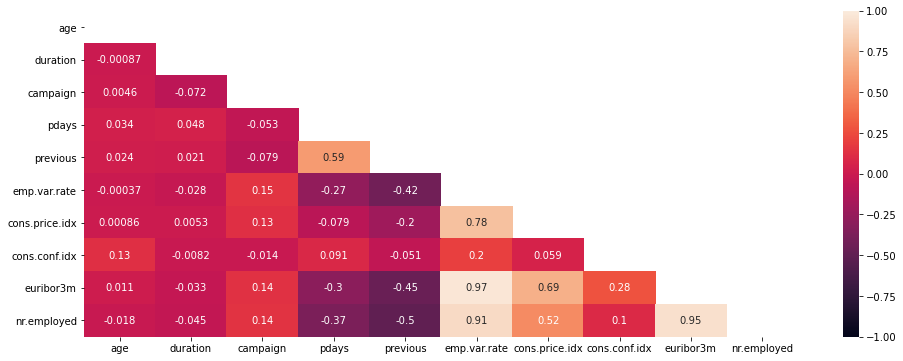

In [258]:
plt.figure(figsize=(16, 6))
mask=np.triu(np.ones_like(df.corr()))
sns.heatmap(df.corr(), annot=True,vmin=-1,vmax=1,mask=mask);

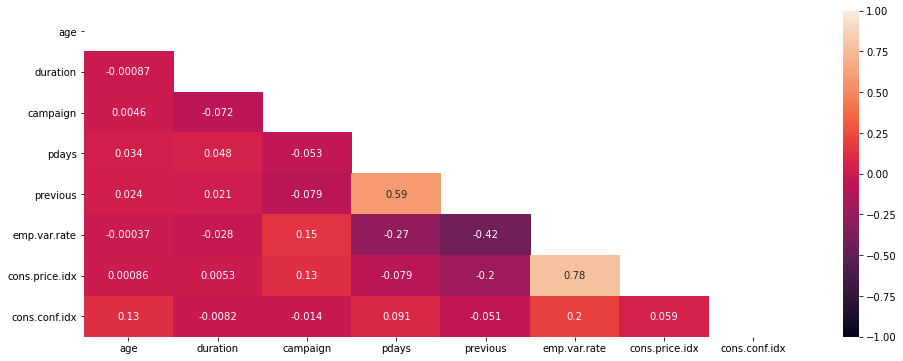

In [259]:
plt.figure(figsize=(16, 6))
mask=np.triu(np.ones_like(df.drop(["nr.employed","euribor3m"],axis="columns").corr()))
sns.heatmap(df.drop(["nr.employed","euribor3m"],axis="columns").corr(), annot=True,vmin=-1,vmax=1,mask=mask);

### **Changes**

In [21]:
df.drop(["nr.employed","euribor3m"],axis="columns")

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,y
0,56,housemaid/blue-collar,married,basic.lower,no,no,no,telephone,may,mon,1,0,0,nonexistent,1.1,93.994,-36.4,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,0,0,nonexistent,1.1,93.994,-36.4,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,0,0,nonexistent,1.1,93.994,-36.4,no
3,40,admin.,married,basic.lower,no,no,no,telephone,may,mon,1,0,0,nonexistent,1.1,93.994,-36.4,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,0,0,nonexistent,1.1,93.994,-36.4,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,0,0,nonexistent,-1.1,94.767,-50.8,yes
41184,46,housemaid/blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,0,0,nonexistent,-1.1,94.767,-50.8,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,0,0,nonexistent,-1.1,94.767,-50.8,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,0,0,nonexistent,-1.1,94.767,-50.8,yes


### 1.6 How is the data in each column distributed?
1. `Age`: Has several outliers, but all fall within reasonable values. They will be kept so as to avoid overfitting the model.
2. `duration`: This column will be removed.
2. `Campaign`: All outliers are within reasonable values.
3. `pdays`: This column has been transformed to categorical and encoded.
4. `previous`: Contains 7 distinct values.
5. Others: None have outliers or unreasonable values.

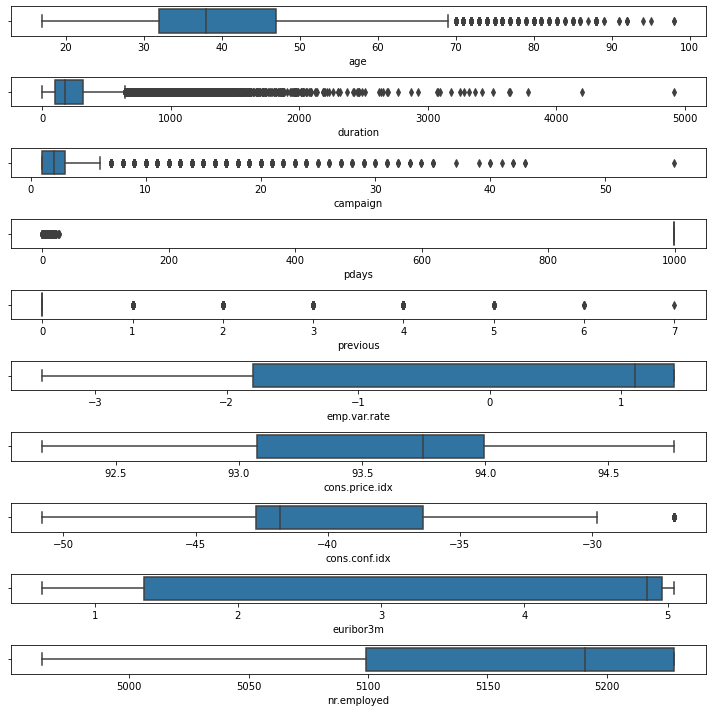

In [149]:
x=df.select_dtypes(include=["int64", "float64"]).copy()
count = 0
fig, ax = plt.subplots(nrows=len(numerical), ncols=1,figsize=(10,10))
for param in x.columns:
    sns.boxplot(x=x[param], ax=ax[count])
    count = count + 1
plt.tight_layout()

# 2 Creating a Data Preparation Pipeline

### 2.1  Listing the Changes:
1. Merge Similar Categories
2. Drop Specific Columns
3. Encode Categorical Columns
4. Change target variable to numerical

### 2.2 Defining the functions

#### 2.2.1 Merging categories

In [14]:
def cat_merger(df):
    # Merge education categories 
    df["education"].replace(["basic.4y","basic.6y"],"basic.lower",inplace=True)
    df["education"].replace("basic.9y","basic.upper",inplace=True)

    # Merge pdays categories
    df["pdays"][df["pdays"] != 999]=1
    df["pdays"][df["pdays"] == 999]=0  

    # Merge job categories
    df["job"].replace(["housemaid","blue-collar"],"housemaid/blue-collar",inplace=True)
    df["job"].replace(["student","unemployed"],"student/unemployed",inplace=True)
    df["job"].replace(["entrepreneur","self-employed"],"entrepeneur/self-employed",inplace=True)
    
    #Replace default categories
    df["default"].replace("yes","unknown",inplace=True)
    
    return df

# Convert function to transformer to include in the pipeline
CatMerger = FunctionTransformer(cat_merger, validate=False)


#### 2.2.2 Dropping Columns

In [15]:
# Drop illogical and correlated columns
def col_dropper(df):
    df.drop(["nr.employed","euribor3m","duration"],axis="columns",inplace=True)
    return df

# Convert function to transformer to include in the pipeline
ColDropper = FunctionTransformer(col_dropper, validate=False)


#### 2.2.3 Encoding Categorical Columns

In [16]:
def categ_encoder(df):
    # Encode all catgeorical columns
    df=pd.get_dummies(df,drop_first=True)
    #Drop unknown columns
    df.drop(["job_unknown","marital_unknown","housing_unknown","loan_unknown"],axis="columns",inplace=True)
    
    return df

# Convert function to transformer to include in the pipeline
CategEncoder = FunctionTransformer(categ_encoder, validate=False)

#### 2.2.4 Changing Target Variable to Numerical

In [17]:
def y_encoder(df):
#changes yes and no categories to binary
    df[df == "yes"]=1
    df[df == "no"]=0
    df=df.astype(int)
    
    return df
# Convert function to transformer to include in the pipeline
YEncoder = FunctionTransformer(y_encoder, validate=False)

### 2.3 Creating the Pipeline

In [18]:
from sklearn.pipeline import Pipeline

# Create Pipelines

pipeline_one = Pipeline([
    ('cat_merger', CatMerger),
    ('col_dropper', ColDropper),
    ('categ_encoder', CategEncoder),
])

pipeline_y = Pipeline([
    ('y_merger', YEncoder),
    ])


# 4 Setting Up the Data

### 3.1 Loading the Data

In [19]:
df=pd.read_csv('Data/bank-full.csv',sep=";")

### 3.2 Splitting the Predictor and Target Variables 

In [20]:
from sklearn.model_selection import train_test_split
y=df["y"]
x=df.drop(["y"],axis="columns")
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=.2,stratify=y,random_state=1)
print(y_train.shape,y_test.shape)
x_train.shape,x_test.shape


(32950,) (8238,)


((32950, 20), (8238, 20))

### 3.3 Fitting and Transforming the Data

In [21]:
x_train=pipeline_one.fit_transform(x_train)
x_test=pipeline_one.transform(x_test)
y_train=pipeline_y.fit_transform(y_train)
y_test=pipeline_y.transform(y_test)
print(y_train.shape,y_test.shape)
print(x_train.shape,x_test.shape)

(32950,) (8238,)
(32950, 41) (8238, 41)


C:\Users\User\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
<ipython-input-14-4ddbbda0af9a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pdays"][df["pdays"] != 999]=1
C:\Users\User\anaconda3\lib\site-packages\pandas\core\generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
<ipython-input-14-4ddbbda0af

# 4 Creating the Model

### 4.1 Testing Scaler and Agortihm Combinations

**Since the foundation of lead scoring is to assign a score to each new lead depending on the probability that they convert, we must use an algortihm that supports the `predict_proba` method.**

In [8]:
from sklearn.preprocessing import StandardScaler as SC
from sklearn.preprocessing import RobustScaler as RS
from sklearn.preprocessing import MinMaxScaler as MN
from sklearn.preprocessing import MaxAbsScaler as MAS
from sklearn.preprocessing import Normalizer as Norm
from sklearn.preprocessing import QuantileTransformer as QT

In [9]:
from sklearn.linear_model import SGDClassifier as SGD
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegressionCV as LR
from sklearn.naive_bayes import BernoulliNB as NB
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neighbors import KNeighborsClassifier as KN

In [10]:
dict_classifiers = {
    "SGD": SGD(),
    "LDA": LDA(),
    "LR": LR(max_iter=10000),
    "NB": NB(),
    "RF": RF(),
    "GBC": GBC(),
    "DTC": DTC(),
    "KN": KN(),
    
}

dict_scalers = {
    "SC": SC(),
    "RS": RS(),
    "MN": MN(),
    "MAS": MAS(),
    "Norm": Norm(),
    "QT": QT(),
}

In [11]:
results = pd.DataFrame(columns=["Algorithm","Scaler","F1_Score","Cohen_Kappa"],index=range(len(dict_classifiers)*len(dict_scalers)))

In [38]:
x=0
for algorithm, a in dict_classifiers.items():
    for scaler, s in dict_scalers.items():
        sc_x=s
        sc_x_train= sc_x.fit_transform(x_train)
        sc_x_test= sc_x.fit_transform(x_test)
        rf =a.fit(sc_x_train, y_train)
        test_pred = rf.predict(sc_x_test)
        print(a, "/", s, ":", f1_score(y_test, test_pred))
        results["Algorithm"][x]=a
        results["Scaler"][x]=s
        results["F1_Score"][x]=f1_score(y_test, test_pred)
        results["Cohen_Kappa"][x]=cohen_kappa_score(y_test, test_pred)
        x=x+1
        results.sort_values(by="F1_Score",ascending=False)

SGDClassifier() / StandardScaler() : 0.3801039346696362
SGDClassifier() / RobustScaler() : 0.32436837815810915
SGDClassifier() / MinMaxScaler() : 0.32384052074857606
SGDClassifier() / MaxAbsScaler() : 0.32384052074857606
SGDClassifier() / Normalizer() : 0.0
SGDClassifier() / QuantileTransformer() : 0.32384052074857606
LinearDiscriminantAnalysis() / StandardScaler() : 0.45925925925925926
LinearDiscriminantAnalysis() / RobustScaler() : 0.4320742213386348
LinearDiscriminantAnalysis() / MinMaxScaler() : 0.45781637717121587
LinearDiscriminantAnalysis() / MaxAbsScaler() : 0.45550715619166143
LinearDiscriminantAnalysis() / Normalizer() : 0.39919082939986517
LinearDiscriminantAnalysis() / QuantileTransformer() : 0.4414039262343843
LogisticRegressionCV(max_iter=10000) / StandardScaler() : 0.33901054339010545
LogisticRegressionCV(max_iter=10000) / RobustScaler() : 0.31833333333333336
LogisticRegressionCV(max_iter=10000) / MinMaxScaler() : 0.32923832923832924
LogisticRegressionCV(max_iter=10000) 

In [39]:
results.sort_values(by="F1_Score",ascending=False)

,Algorithm,Scaler,F1_Score,Cohen_Kappa
6,LinearDiscriminantAnalysis(),StandardScaler(),0.459259,0.401678
8,LinearDiscriminantAnalysis(),MinMaxScaler(),0.457816,0.400506
9,LinearDiscriminantAnalysis(),MaxAbsScaler(),0.455507,0.398221
11,LinearDiscriminantAnalysis(),QuantileTransformer(),0.441404,0.378702
7,LinearDiscriminantAnalysis(),RobustScaler(),0.432074,0.37813
19,BernoulliNB(),RobustScaler(),0.415929,0.355943
10,LinearDiscriminantAnalysis(),Normalizer(),0.399191,0.343869
23,BernoulliNB(),QuantileTransformer(),0.398087,0.330965
20,BernoulliNB(),MinMaxScaler(),0.398087,0.330965
27,"(DecisionTreeClassifier(max_features='auto', r...",MaxAbsScaler(),0.394109,0.342367


### **LDA works the best, but we cannot tune the model. We will thus go a random forest, which is the the best among the tunable models. We will also use the Robust Scaler.**

In [ ]:
#Calling the Scaler
sc_x=RS()
sc_x_train= sc_x.fit_transform(x_train)
sc_x_test= sc_x.fit_transform(x_test)

#random forest with randomized search

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              }


rf = RF()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(sc_x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.3min


In [56]:
from sklearn.ensemble import RandomForestRegressor

### 3.3 Testing Random Forest Grid with Standard Scaler

In [1]:
sc_x=StandardScaler()
sc_x_train= sc_x.fit_transform(x_train)
sc_x_test= sc_x.fit_transform(x_test)
#random forest with randomized search
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              }
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(sc_x_train, y_train)


NameError: name 'StandardScaler' is not defined

In [207]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [238]:
sc_x=StandardScaler()
sc_x_train= sc_x.fit_transform(x_train)
sc_x_test= sc_x.fit_transform(x_test)
sc_x_actual=sc_x.fit_transform(x_actual)
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators= 400, min_samples_split= 2, min_samples_leaf= 1, max_features= 'sqrt', max_depth= None, bootstrap= False)
rf.fit(sc_x_train, y_train)
test_pred = rf.predict(sc_x_test)
print(" RMSE: "+ str(metrics.mean_squared_error(y_test, test_pred)**.5))
actual_pred=rf.predict(sc_x_actual)


 RMSE: 0.6295695382031035
